# Generate samples using steady state simulation

In [11]:
# Use steady state simulation to generate samples
# Then approximate the resulting correlation matrix with GGM

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from ddn3 import tools
from iddn_paper import sim3_h5op, tool_sys, sim3_network_toy
from iddn_paper.old_functions import sim3_network_topo as nett, sim3_steady_state_batch

top_folder = tool_sys.get_work_folder() + "/experiment_iddn_paper/"

In [12]:
reload(nett)
reload(sim3_network_toy)

n_sample_gen = 10000  # 10000
sigma_in = 2.0
sigma_mid = 2.0

hill_coef = 1.0  # 1.0
two_condition_ratio = 0.25  # 0.25

# n_hub = 1
# hub_to_gene = 10
# hub_to_tf = 20
# tf_to_gene = 3

n_hub = 2
hub_to_gene = 5
hub_to_tf = 10
tf_to_gene = 2

# Skeleton
mol_layer = dict()
mol_par = dict()
mol_par_roles = dict()
for n in range(n_hub):
    sim3_network_toy.add_one_hub_net(
        mol_layer,
        mol_par,
        mol_par_roles,
        hub_to_tf,
        hub_to_gene,
        tf_to_gene,
        net_idx=n,
    )

# Make two conditions by removing some edges in each condition
mol_par1, mol_par2, mol_par_roles1, mol_par_roles2 = nett.make_two_conditions_mol_net(
    mol_par,
    mol_par_roles,
    ratio=two_condition_ratio,
)

# Simulation for each condition

net_info, dep_mat, con_mat = nett.prep_net_for_sim(
    mol_layer,
    mol_par,
    mol_par_roles,
    mol_type=None,
)
net_info1, dep_mat1, con_mat1 = nett.prep_net_for_sim(
    mol_layer,
    mol_par1,
    mol_par_roles1,
    mol_type=None,
)
net_info2, dep_mat2, con_mat2 = nett.prep_net_for_sim(
    mol_layer,
    mol_par2,
    mol_par_roles2,
    mol_type=None,
)
dep_mat_null = np.ones_like(dep_mat1)
dep_mat_prior, dep_mat_prior_loose = sim3_network_toy.make_iddn_dep_prior(mol_layer, net_info1["mol2idx"])
comm_gt, diff_gt = tools.get_common_diff_net_topo([con_mat1, con_mat2])


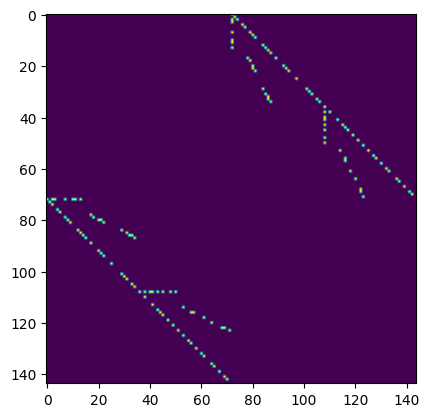

In [13]:
plt.imshow(comm_gt)

In [14]:
# TODO: make the sigma distribution more realistic
sigma_mid_vec = np.zeros(len(mol_layer)) + sigma_mid
if 1:
    for key, val in net_info1['idx2mol'].items():
    
        if val[9].isnumeric():
            if int(val[9])%2 == 0:
                sigma_mid_vec[key] = np.random.uniform(low=0.5, high=1.5)  # 0.5
            else:
                sigma_mid_vec[key] = np.random.uniform(low=1.5, high=2.5) # 2
        else:
            # print(val)
            sigma_mid_vec[key] = np.random.uniform(low=0.5, high=2.5)
    
        # if val[4]=='0':
        #     sigma_mid_vec[key] = np.random.uniform(low=0.5, high=1.5)  # 0.5
        # else:
        #     sigma_mid_vec[key] = np.random.uniform(low=1.5, high=2.5) # 2


In [15]:
reload(sim3_steady_state_batch)
dat1, state_history1, noise_history1 = sim3_steady_state_batch.run_sim(
    net_info1["idx_layer"],
    net_info1["idx_par"],
    net_info1["idx_par_roles"],
    n_sample=n_sample_gen,
    n_max_steps=100,
    method="steady",
    sigma_in=sigma_in,
    sigma_mid=sigma_mid_vec,
    hill_coef=hill_coef,
)
dat2, state_history2, noise_history2 = sim3_steady_state_batch.run_sim(
    net_info2["idx_layer"],
    net_info2["idx_par"],
    net_info2["idx_par_roles"],
    n_sample=n_sample_gen,
    n_max_steps=100,
    method="steady",
    sigma_in=sigma_in,
    sigma_mid=sigma_mid_vec,
    hill_coef=hill_coef,
)


In [16]:
# v1 allows removing the translation edges
# This makes evaluation of differential network easier
# Sigma: target, low mean, high mean
idx = np.random.randint(1000000)
exp_name = (
    f"sim3_tf_mrna_n-hub_{n_hub}_n-node_{len(con_mat1)}_hill_{hill_coef}_sigma_bi_2_1_2_odd_even"
    f"_ratio_{two_condition_ratio}_n_{n_sample_gen}_{idx}"
)
dat_file = f"{top_folder}/sim_input/{exp_name}.hdf5"

reload(sim3_h5op)
if 0:
    sim3_h5op.make_new_sim_data(
        dat_file,
        dat1,
        dat2,
        con_mat1,
        con_mat2,
        comm_gt=comm_gt,
        diff_gt=diff_gt,
        dep_mat_null=dep_mat_null,
        dep_mat_prior=dep_mat_prior,
        dep_mat_prior_loose=dep_mat_prior_loose,
        layer_count=net_info1["layer_count"],
    )


In [17]:
# plt.imshow(dep_mat_prior)
print(exp_name)

sim3_tf_mrna_n-hub_2_n-node_144_hill_1.0_sigma_bi_2_1_2_odd_even_ratio_0.25_n_10000_358968


## Debug

In [18]:
g1_cov = np.corrcoef(dat1.T)
g2_cov = np.corrcoef(dat2.T)
# omega_org = np.linalg.inv(cc)
# # omega_org[np.abs(omega_org) < 0.4] = 0
# # omega1 = np.copy(omega_org)
# # omega2 = np.copy(omega_org)
# plt.figure(); plt.imshow(np.abs(cc)); plt.clim(0, 1); plt.show()
# plt.figure(); plt.imshow(np.abs(omega_org)); plt.clim(0, 1); plt.show()

0.03564668826041023
0.03240064668090162


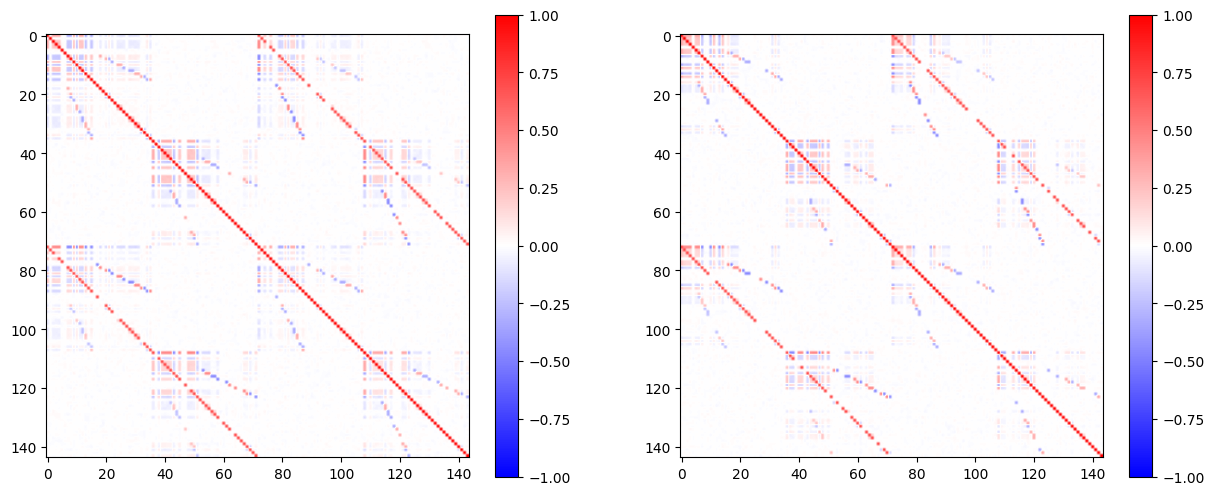

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
print(np.mean(np.abs(g1_cov)))
print(np.mean(np.abs(g2_cov)))

im0 = ax[0].imshow(g1_cov, cmap="bwr")
im1 = ax[1].imshow(g2_cov, cmap="bwr")
im0.set_clim(-1,1)
im1.set_clim(-1,1)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


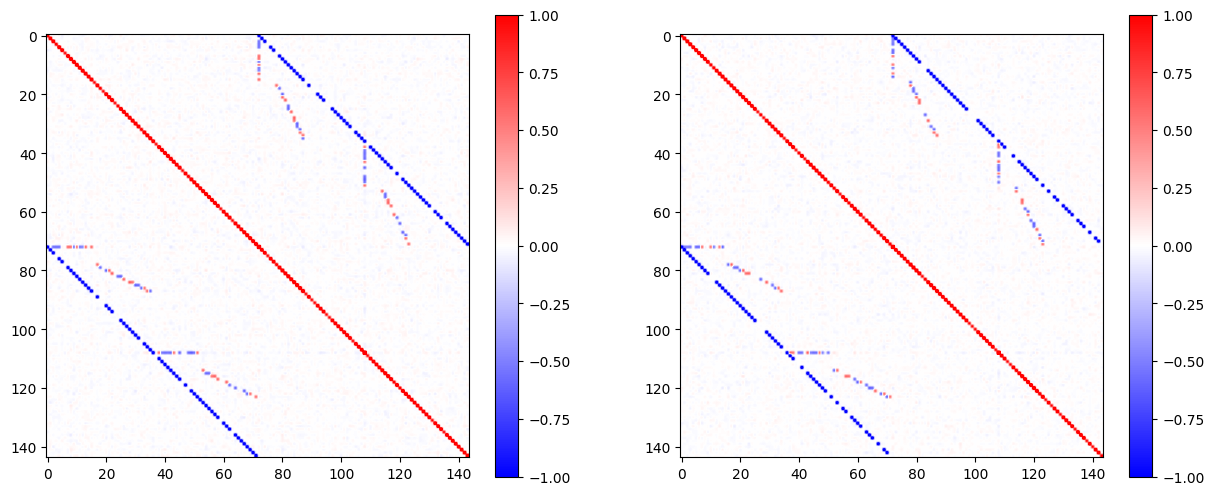

In [20]:
omega1 = np.linalg.inv(g1_cov)
omega2 = np.linalg.inv(g2_cov)

fig, ax = plt.subplots(1,2,figsize=(15, 6))
im0 = ax[0].imshow(omega1, cmap="bwr")
im1 = ax[1].imshow(omega2, cmap="bwr")
im0.set_clim(-1,1)
im1.set_clim(-1,1)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
